In [1]:
import os
from sklearn.cluster import AgglomerativeClustering
from keras.preprocessing.image import ImageDataGenerator, smart_resize, DirectoryIterator
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from scipy.cluster.hierarchy import dendrogram , linkage
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from sklearn.utils import parallel_backend
from joblibspark import register_spark

In [3]:
register_spark()

In [4]:
main_dir = "../data/Images"

# Setting path to the training directory
train_dir = os.path.join(main_dir, 'train')

# Setting path to the test directory
test_dir = os.path.join(main_dir, 'val')

# Directory with train animal_crossing images
train_ac_dir = os.path.join(train_dir, 'animal_crossing')

# Directory with train Doom images
train_doom_dir = os.path.join(train_dir, 'doom')

# Directory with test animal_crossing image
test_ac_dir = os.path.join(test_dir, 'animal_crossing')

# Directory with test doom image
test_doom_dir = os.path.join(test_dir, 'doom')

# Creating a list of filenames in each directory
train_ac_names = os.listdir(train_ac_dir)
print(train_ac_names[:10])  # printing a list of the first 10 filenames

train_doom_names = os.listdir(train_doom_dir)
print(train_doom_names[:10])

test_ac_names = os.listdir(test_ac_dir)
print(test_ac_names[:10])

test_doom_names = os.listdir(test_doom_dir)
print(test_doom_names[:10])

# Printing total number of images present in each set
print('Total no of images in training set:', len(train_ac_names
                                                + train_doom_names))
print("Total no of images in test set:", len(test_ac_names
                                            + test_doom_names))

['manh6kzaxm051.jpg', 'yutte0d7fn151.png', 'wiyl0tl0n8r41.jpg', 'lxdsmtwgb9x41.jpg', '0d95wo29cl051.jpg', 'sgch1t0ubfu41.jpg', 'kdma33kq3l051.jpg', 'lnl5o58dcow41.jpg', '3ffya37h56v41.jpg', 'kzabkt8igdu41.jpg']
['i8m7jw1p49x31.jpg', '72twsly4v7i41.jpg', '6mfhsgu63hx41.jpg', 'mbgapc4q9js41.jpg', 'numuacocm9931.jpg', 'h5ji97z44hs41.png', '1snibvl6zpp41.jpg', '2jawonnlz6s41.png', 'izbtuqy7ybl41.jpg', 'jk1lza5gw3h41.jpg']
['t1u2dgqe8sp41.jpg', '5yu10oi529u41.jpg', 'wgwa7ynh4au41.jpg', 'b5x6s7la21v41.jpg', 'jqzzyw1w8ms41.jpg', 'zergm3hguss41.jpg', 'ufmdogx78lx41.jpg', 'jappvd4wmbt41.jpg', 'fbhxzlep62251.jpg', 'll7xid3fqmu41.jpg']
['etqyw0pbk1u41.jpg', 'of5t94mga4i21.jpg', 'ugzimfspx2p41.jpg', 'fw1xeqqqnzl31.jpg', 'pp338396rcz41.jpg', 'g26xfqqcein41.jpg', '1kunist4yeq31.jpg', 'jb2x2o4tfim41.png', '60m316tz31741.jpg', 'rbq9w51b88o41.png']
Total no of images in training set: 1436
Total no of images in test set: 161


In [5]:
# Data Visualization
import matplotlib.image as mpimg
# Setting the no of rows and columns
ROWS = 4
COLS = 4
# Setting the figure size
fig = plt.gcf()
# get current figure; allows us to get a reference to current figure when using pyplot
fig.set_size_inches(12, 12)
# get the directory to each image file in the trainset
ac_pic = [os.path.join(train_ac_dir, filename) for filename in train_ac_names[:8]]
doom_pic = [os.path.join(train_doom_dir, filename) for filename in train_doom_names[:8]]
print(ac_pic)
print(doom_pic)
# merge ac and doom lists
merged_list = ac_pic + doom_pic
print(merged_list)

['../data/Images/train/animal_crossing/manh6kzaxm051.jpg', '../data/Images/train/animal_crossing/yutte0d7fn151.png', '../data/Images/train/animal_crossing/wiyl0tl0n8r41.jpg', '../data/Images/train/animal_crossing/lxdsmtwgb9x41.jpg', '../data/Images/train/animal_crossing/0d95wo29cl051.jpg', '../data/Images/train/animal_crossing/sgch1t0ubfu41.jpg', '../data/Images/train/animal_crossing/kdma33kq3l051.jpg', '../data/Images/train/animal_crossing/lnl5o58dcow41.jpg']
['../data/Images/train/doom/i8m7jw1p49x31.jpg', '../data/Images/train/doom/72twsly4v7i41.jpg', '../data/Images/train/doom/6mfhsgu63hx41.jpg', '../data/Images/train/doom/mbgapc4q9js41.jpg', '../data/Images/train/doom/numuacocm9931.jpg', '../data/Images/train/doom/h5ji97z44hs41.png', '../data/Images/train/doom/1snibvl6zpp41.jpg', '../data/Images/train/doom/2jawonnlz6s41.png']
['../data/Images/train/animal_crossing/manh6kzaxm051.jpg', '../data/Images/train/animal_crossing/yutte0d7fn151.png', '../data/Images/train/animal_crossing/wiy

<Figure size 864x864 with 0 Axes>

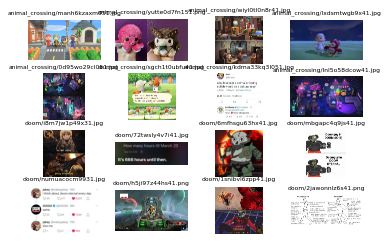

In [6]:
# Plotting the images in the merged list
for i, img_path in enumerate(merged_list):
    # getting the filename from the directory
    data = img_path.split('/', 4)[4]
    # creating a subplot of images with the no. of rows and colums with index no
    sp = plt.subplot(ROWS, COLS, i+1)
    # turn off axis
    sp.axis('Off')
    # reading the image data to an array
    img = mpimg.imread(img_path)
    # setting title of plot as the filename
    sp.set_title(data, fontsize=6)
    # displaying data as image
    plt.imshow(img, cmap='viridis')
    
plt.show()  # display the plot


In [7]:
dgen_train = ImageDataGenerator(rescale=1./255,
                                validation_split=0.2,
                                zoom_range=0.2,
                                horizontal_flip=True)
dgen_validation = ImageDataGenerator(rescale=1./255)
dgen_test = ImageDataGenerator(rescale=1./255)


TARGET_SIZE = (200, 200)
BATCH_SIZE = 1
CLASS_MODE = 'binary'


train_generator = dgen_train.flow_from_directory(train_dir,
                                                 target_size=TARGET_SIZE,
                                                 batch_size=BATCH_SIZE,
                                                 class_mode=CLASS_MODE)

Found 1436 images belonging to 2 classes.


In [8]:
train_df = pd.DataFrame()
for _ in range(train_generator.n):
    img, label = train_generator.next()
    img = img.reshape(1,-1)
    feat_labels = ["Pixel_"+str(i) for i in range(img.shape[1])]
    data = {name:pix for name,pix in zip(feat_labels, img[0])}
    data['label'] = int(label[0])
    train_df = train_df.append(data, ignore_index=True)
print("Training Set Flattened")

Training Set Flattened


In [9]:
df = train_df.iloc[:,:-1]
true_labels = train_df['label']

# Ward Linkage

In [42]:
#Creating the model
# Ward linkage seeks to minimize the total within cluster variance
agg_clustering = AgglomerativeClustering(n_clusters = 2, affinity = 'euclidean', linkage = 'ward')


#predicting the labels
with parallel_backend('spark', n_jobs=-1): 
    labels = agg_clustering.fit_predict(df)

In [43]:
print(classification_report(true_labels, labels))

              precision    recall  f1-score   support

         0.0       0.58      0.63      0.60       676
         1.0       0.64      0.60      0.62       760

    accuracy                           0.61      1436
   macro avg       0.61      0.61      0.61      1436
weighted avg       0.61      0.61      0.61      1436



In [44]:
print(confusion_matrix(true_labels, labels))

[[423 253]
 [307 453]]


In [45]:
#Linkage Matrix
with parallel_backend('spark', n_jobs=-1): 
    Z = linkage(df, method = 'ward')

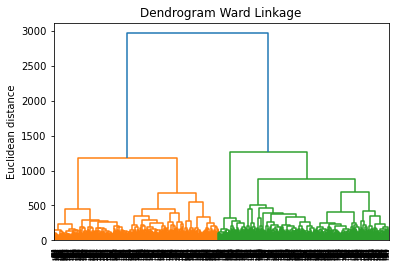

In [46]:
#plotting dendrogram
dendro = dendrogram(Z)
plt.title('Dendrogram Ward Linkage')
plt.ylabel('Euclidean distance')
plt.savefig('DendrogramWard.png', dpi=300)
plt.show()

# Complete Linkage

In [47]:
#Creating the model
# Ward linkage seeks to minimize the total within cluster variance
agg_clustering = AgglomerativeClustering(n_clusters = 2, affinity = 'euclidean', linkage = 'complete')


#predicting the labels
with parallel_backend('spark', n_jobs=-1): 
    labels = agg_clustering.fit_predict(df)

In [48]:
print(classification_report(true_labels, labels))

              precision    recall  f1-score   support

         0.0       0.56      0.76      0.64       676
         1.0       0.68      0.47      0.55       760

    accuracy                           0.60      1436
   macro avg       0.62      0.61      0.60      1436
weighted avg       0.62      0.60      0.59      1436



In [49]:
print(confusion_matrix(true_labels, labels))

[[511 165]
 [406 354]]


In [50]:
#Linkage Matrix
with parallel_backend('spark', n_jobs=-1): 
    Z = linkage(df, method = 'complete')

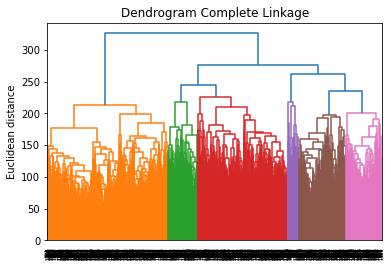

In [51]:
#plotting dendrogram
dendro = dendrogram(Z)
plt.title('Dendrogram Complete Linkage')
plt.ylabel('Euclidean distance')
plt.savefig('DendrogramComplete.png', dpi=300)
plt.show()

# Average Linkage

In [52]:
#Creating the model
# Ward linkage seeks to minimize the total within cluster variance
agg_clustering = AgglomerativeClustering(n_clusters = 2, affinity = 'euclidean', linkage = 'average')


#predicting the labels
with parallel_backend('spark', n_jobs=-1): 
    labels = agg_clustering.fit_predict(df)

In [53]:
print(classification_report(true_labels, labels))

              precision    recall  f1-score   support

         0.0       0.47      0.82      0.60       676
         1.0       0.53      0.17      0.26       760

    accuracy                           0.48      1436
   macro avg       0.50      0.50      0.43      1436
weighted avg       0.50      0.48      0.42      1436



In [54]:
print(confusion_matrix(true_labels, labels))

[[557 119]
 [628 132]]


In [55]:
#Linkage Matrix
with parallel_backend('spark', n_jobs=-1): 
    Z = linkage(df, method = 'average')

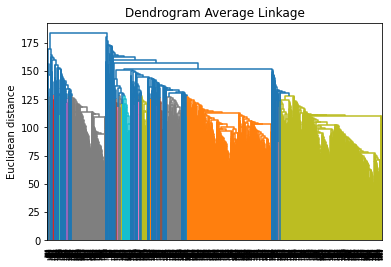

In [56]:
#plotting dendrogram
dendro = dendrogram(Z)
plt.title('Dendrogram Average Linkage')
plt.ylabel('Euclidean distance')
plt.savefig('DendrogramAverage.png', dpi=300)
plt.show()

# Single Linkage

In [57]:
#Creating the model
# Ward linkage seeks to minimize the total within cluster variance
agg_clustering = AgglomerativeClustering(n_clusters = 2, affinity = 'euclidean', linkage = 'single')


#predicting the labels
with parallel_backend('spark', n_jobs=-1): 
    labels = agg_clustering.fit_predict(df)

In [58]:
print(classification_report(true_labels, labels))

              precision    recall  f1-score   support

         0.0       0.47      1.00      0.64       676
         1.0       1.00      0.00      0.00       760

    accuracy                           0.47      1436
   macro avg       0.74      0.50      0.32      1436
weighted avg       0.75      0.47      0.30      1436



In [59]:
print(confusion_matrix(true_labels, labels))

[[676   0]
 [759   1]]


In [60]:
#Linkage Matrix
with parallel_backend('spark', n_jobs=-1): 
    Z = linkage(df, method = 'single')

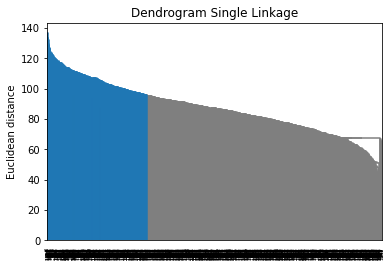

In [61]:
#plotting dendrogram
dendro = dendrogram(Z)
plt.title('Dendrogram Single Linkage')
plt.ylabel('Euclidean distance')
plt.savefig('DendrogramSingle.png', dpi=300)
plt.show()